In [162]:
!pip install wget
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import json
import wget
import os

In [164]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print( torch.cuda.device_count())
    print('Available:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


4
Available: NVIDIA A100-SXM4-80GB


In [165]:
def word_shape_features(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha(),word.isalnum(), word.isnumeric()])

def get_word_features(word):
    return word_shape_features(word)

def get_sent_features(sent):
    ret = []
    for word in sent:
        ret.append(get_word_features(word))
    return ret

In [166]:
TAGS =  pickle.load(open( "tags.pickle", "rb" ))
TAGS.remove("O") 
NUM_TAGS = len(TAGS)

tag2id = {}
for id,label in enumerate(TAGS):
    tag2id[label] = id 

def label2id(labels):
    ret = []
    prev_label = ""
    for label in labels:
        if label == "O":
            ret.append([2*NUM_TAGS])
        elif label == prev_label:
            l =[tag2id[t]+ NUM_TAGS for t in label]
            ret.append(l)
        else:
            l =[tag2id[t] for t in label]
            ret.append(l)
        prev_label = label
    return ret 

In [167]:
def get_label(label_id):
    if label_id == (2*NUM_TAGS):
        return "O"
    elif label_id >= NUM_TAGS:
        return [TAGS[label_id-NUM_TAGS]]
    else:
        return TAGS[label_id]

def id2label(labels):
    ret = []
    for label in labels:
        l = [get_label(x) for x in label]
        if len(l) == 1 and l[0] == "O":
            l = "O"
        ret.append(l)
    return ret 


In [168]:
import regex as re
def clean_text(sent):
    '''
    This is text cleaning function
    '''
    ret_sent= []
    for txt in sent:
#       if len(txt) < 1:
# #         print("HI",txt, sent)
#         return -1
      fil_txt = re.sub('[^A-Za-z0-9]+', '', str(txt))
      if len(fil_txt) == 0:
        fil_txt  = txt [0]
      ret_sent.append(fil_txt)
    assert(len(ret_sent) == len(sent))
    return ret_sent

In [169]:
clean_text(["---ABC", "--"])

['ABC', '-']

In [170]:
f = open('data/train.json')
data = json.load(f)
f.close()


In [171]:
a = [d["sent"] for d in data]
set_ = set()
for idx,s in enumerate(a):
    for t in s:
        if len(t)<1:
            set_.add(idx)
data = [data[i] for i in range(len(data)) if i not in set_]

In [ ]:
len(set_)

In [172]:
import pandas as pd
df = pd.DataFrame(data)

In [101]:
# df = df[:200]

In [173]:
df["sent"] = df["sent"].map( lambda x: clean_text(x))

In [174]:
df["labels"] = df["tags"].map(lambda x: label2id(x))

In [118]:
# df

In [175]:
from transformers import BertTokenizer
import numpy as np
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [176]:
sentences = list(df["sent"])


In [177]:
labels = list(df["labels"])


In [178]:
print("Number of training sentences: {:,}".format(len(sentences)))


Number of training sentences: 1,247,626


In [179]:
from tqdm import tqdm 
mt = []
for i in tqdm(sentences):
    mt.append(len(tokenizer.encode(' '.join(i),add_special_tokens=True)))


100%|███████████████████████████████| 1247626/1247626 [13:33<00:00, 1533.13it/s]


In [180]:
TokenLength = [x for x in mt if x >100]

In [181]:
to_retain = [i for i,x in enumerate(mt) if x <103]

In [182]:
sentences = [ sentences[i] for i in to_retain]


In [183]:
labels =  [ labels[i] for i in to_retain]

In [184]:
len(mt), len(TokenLength), len(labels)

(1247626, 169, 1247486)

In [185]:
print('Minimum  length: {:,} tokens'.format(min(mt)))
print('Maximum length: {:,} tokens'.format(max(mt)))
print('Median length: {:,} tokens'.format(int(np.median(mt))))


Minimum  length: 17 tokens
Maximum length: 405 tokens
Median length: 33 tokens


In [186]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [187]:
from tqdm import tqdm

/tmp/ipykernel_576/412008344.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mt, kde=False, rug=False,color='plum')


Text(0.5, 0, 'Sentence Length')

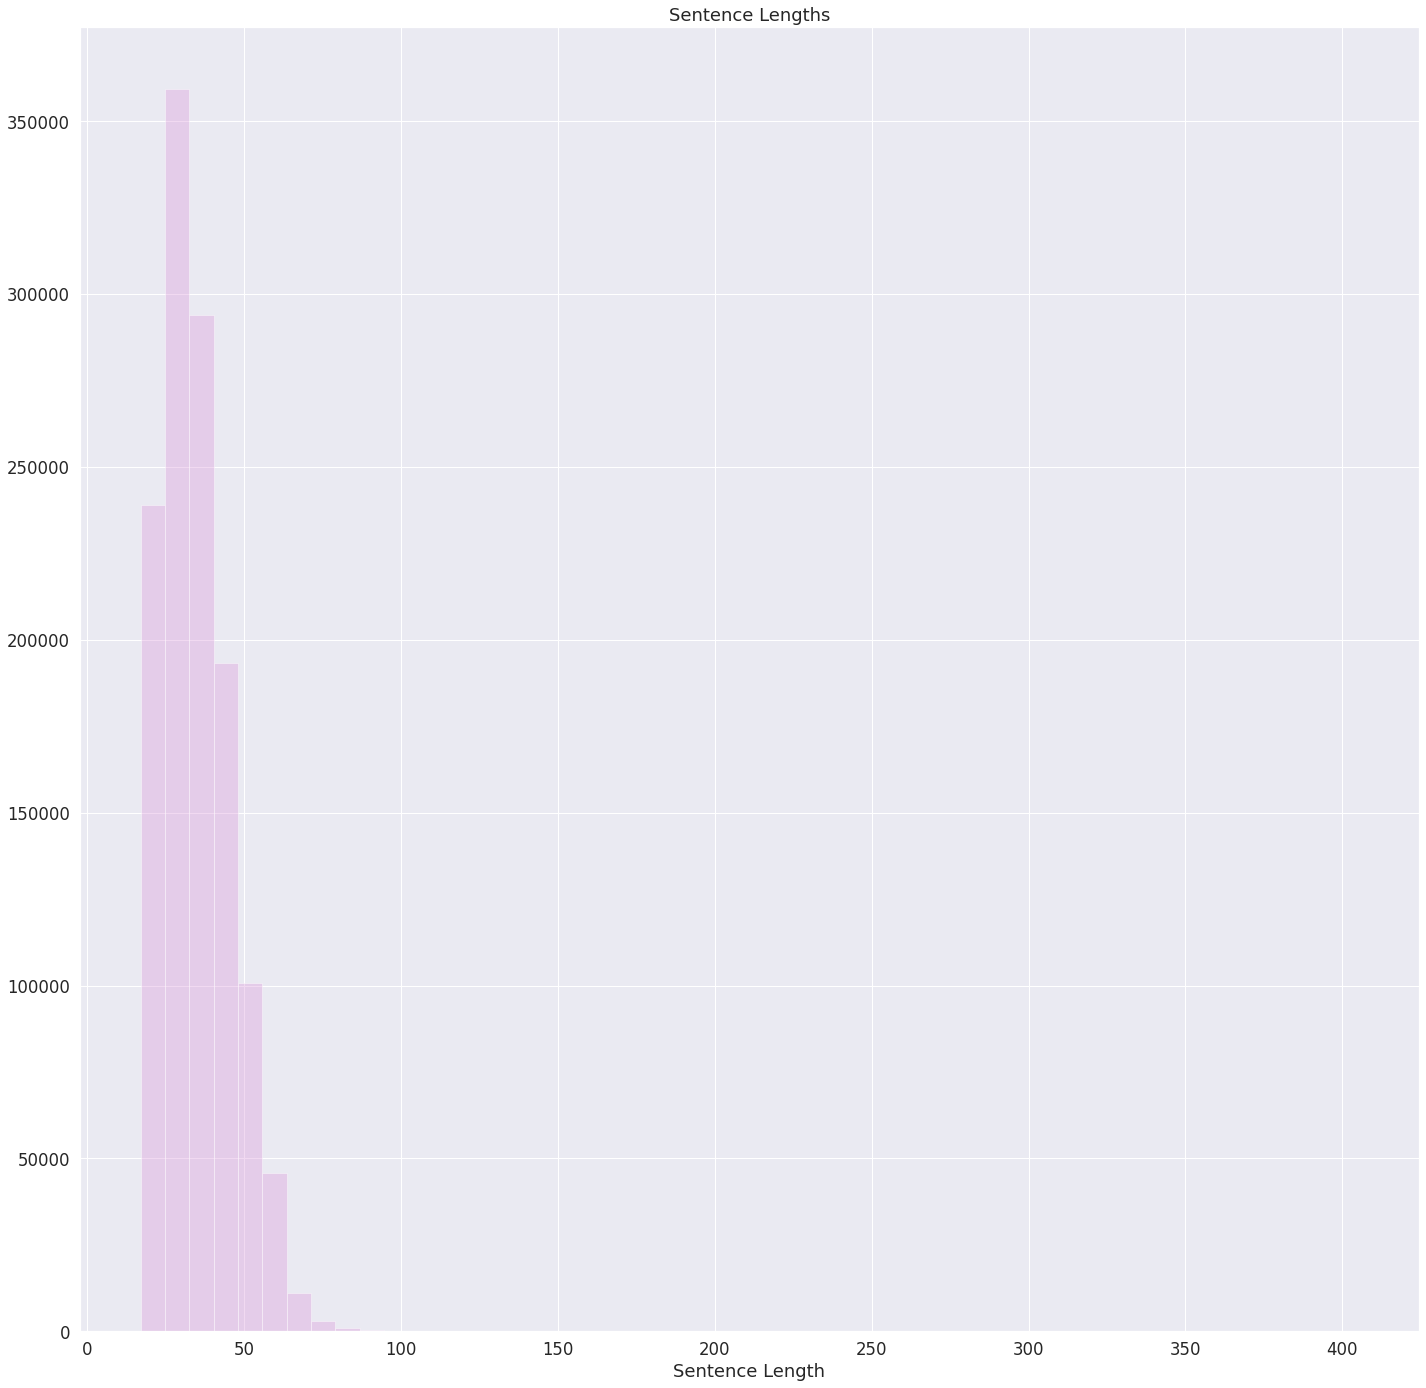

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.figure(figsize=(24,24))
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(mt, kde=False, rug=False,color='plum')

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')


In [189]:
SampleSentence=tokenizer.encode_plus("- abc", add_special_tokens = True,truncation = True,max_length = 100,padding = True,return_attention_mask = True, return_tensors = 'pt')
SampleSentence

{'input_ids': tensor([[ 101, 1011, 5925,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [190]:
tokenizer.ids_to_tokens[1011]

'-'

In [191]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

input_ids = []
attention_masks = []

for sent in tqdm(sentences):

    sent_str = ' '.join(sent)
#     print(len(sent))
#     print(sent_str)
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                 
                        add_special_tokens = False,
                        truncation = True,
                        max_length = 105,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    
        
    input_ids.append(encoded_dict['input_ids'][0])
    
    # And its attention mask
    attention_masks.append(encoded_dict['attention_mask'][0])
    # break

# print('Original: ', sentences[24])
# print('Token IDs:', input_ids[24])
# print('Masks:', attention_masks[24])


100%|███████████████████████████████| 1247486/1247486 [15:03<00:00, 1381.13it/s]


In [192]:
i11 = input_ids.copy()
i12 = attention_masks.copy()
i13= labels.copy()

In [140]:
# input_ids = input_ids[:2000]
# attention_masks = attention_masks[:2000]
# labels = labels[:2000]

In [193]:
def to_bool_vec(y_id):
    y_bool = np.zeros(2*NUM_TAGS+1, np.int32)
    num_labels = len(y_id)
    for id in y_id:
        # for l in label:
          y_bool[id] = 1
    return y_bool


In [194]:
new_labels = []

# The special label ID we'll give to "extra" tokens.
to_remove_idx = []
null_label_id =  np.zeros(2*NUM_TAGS+1, np.int32) #-100
idx = 0
for (tokens, masks, orig_labels) in zip(input_ids, attention_masks, labels):
    
    padded_labels = []
    ty = 0
    orig_labels_i = 0 
    # print(tokens, masks, orig_labels)

    for token_id,mask_id in zip(tokens,masks):
      token_id = token_id.numpy().item()

      if mask_id.numpy().item() == 0:
        padded_labels.append(null_label_id)
      

      elif (token_id == tokenizer.pad_token_id) or \
          (token_id == tokenizer.cls_token_id) or \
          (token_id == tokenizer.sep_token_id):
          
          padded_labels.append(null_label_id)

      elif tokenizer.ids_to_tokens[token_id][0:2] == '##':

          padded_labels.append(null_label_id)
 
      else:
        # print(tokenizer.ids_to_tokens[token_id], orig_labels_i, len(orig_labels))
        if orig_labels_i >= len(orig_labels):
          ty+=1
          break
        else:
          
          padded_labels.append(to_bool_vec(orig_labels[orig_labels_i]))
        orig_labels_i += 1

    # assert(len(sen) == len(padded_labels))    
    if ty == 0:
      new_labels.append(padded_labels)
    else:
      to_remove_idx.append(idx)
    idx+=1

In [195]:
print(ty)

0


In [197]:
filtered_attention_masks = [attention_masks[idx] for idx in range(len(attention_masks)) if idx not in to_remove_idx]
filtered_input_ids = [input_ids[idx] for idx in range(len(input_ids)) if idx not in to_remove_idx]


In [198]:
len(input_ids), len(to_remove_idx)

(1247486, 0)

In [ ]:
pt_input_ids = torch.stack(filtered_input_ids, dim=0)

pt_attention_masks = torch.stack(filtered_attention_masks, dim=0)

pt_labels = torch.tensor(new_labels, dtype=torch.float32)


In [ ]:
# for x in pt_labels:
#   for y in x:
#     if torch.sum(y) == 0:
#       print(y)  
#       break

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

print('{:>5,} training samples'.format(len(train_dataset)))



In [ ]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nNew Labels:  ', new_labels[2])
print('\nMask:        ', attention_masks[2])

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 256

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size )

# validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size   )

In [ ]:
from transformers import BertForTokenClassification, AdamW, BertConfig


model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels = len(TAGS)*2 + 1, output_attentions = False, output_hidden_states = False)


# model.cuda()

In [ ]:
model.cuda()

In [ ]:
# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon 
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs 
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


In [ ]:
from torch import nn
from scipy.special import expit


m = nn.Sigmoid()
criterion = nn.BCELoss()

def compute_loss(pred,target):


        sum_mat = torch.sum(target, axis=2)
        flat_pred = pred[sum_mat > 0][:] 
        flat_target  = target[ sum_mat > 0][:]
        # print(criterion(flat_pred, flat_target))
        return criterion(m(flat_pred), flat_target)




In [ ]:
import random
import joblib
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    total_loss = 0

    model.train()
    
    for step, batch in enumerate(train_dataloader):
       
        if step % 40 == 0 and not step == 0:
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
     
        # with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        loss = compute_loss(outputs.logits, b_labels)
        loss.requires_grad_()
        # print(loss.item())
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)
    

    print("  Average training loss: {0:.6f}".format(avg_train_loss))
    filename = "model_{}.h5".format(epoch_i)
    joblib.dump(model, filename)


In [213]:
loss_values

[0.013137829136531498, 0.00339178740256767, 0.0029977163787367023]

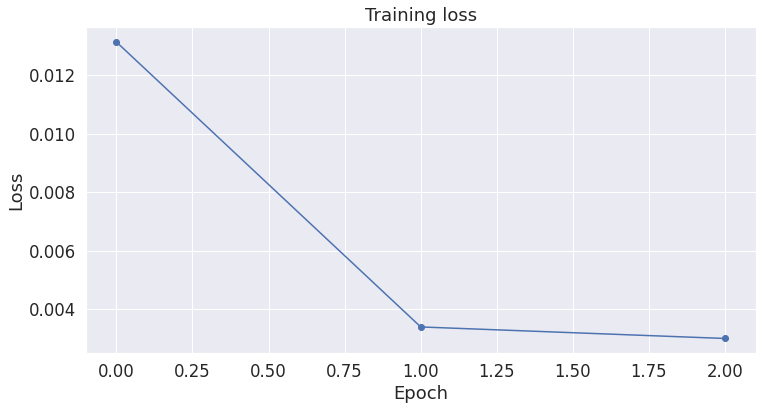

In [214]:
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()